# Sycophancy Evaluation Pipeline - PhD Research Grade

**Phase 1: Evaluate Any LLM for Sycophancy**

This notebook implements a research-grade evaluation pipeline measuring sycophancy using the **Compliance Gap** metric with full statistical rigor.

## Key Features:
- **Compliance Gap Metric**: Δ = P(Sycophantic|Biased) - P(Sycophantic|Neutral)
- **Confidence Filtering**: Detects and handles uncertain model predictions
- **PhD-Level Statistics**: Permutation tests, bootstrap CIs, multiple comparison corrections
- **Three Sycophancy Types**: Opinion, Factual, Reasoning

## Requirements:
- Colab Pro (A100/V100 GPU recommended)
- HuggingFace account with Llama access

## 1. Setup Environment

In [1]:
!python -m pip uninstall -y numpy
!rm -rf /usr/local/lib/python3.12/dist-packages/numpy*

# 1. Install specific compatible versions first
# We manually install transformer_lens dependencies since we use --no-deps later
!python -m pip install "numpy==1.26.4" "beartype>=0.14.1,<0.15.0" "better_abc>=0.0.3,<0.0.4" "fancy_einsum>=0.0.3" "transformers_stream_generator>=0.0.5"

# 2. Install main dependencies, strictly pinning numpy<2.0
!python -m pip install --upgrade \
  "numpy<2.0" torch transformers accelerate einops datasets pandas scikit-learn scipy tqdm jaxtyping

# 3. Install transformer_lens
!python -m pip install --no-deps transformer_lens

# 4. FORCE numpy version again as the final step to overwrite any unwanted upgrades
!python -m pip install --force-reinstall "numpy==1.26.4"

# 5. Final verification
!python -c "import numpy; print(f'Final Installed NumPy: {numpy.__version__}')"

print("\n" + "="*60)
print("SETUP COMPLETE.")
print("IF YOU SAW AN ERROR BEFORE, PLEASE GO TO 'Runtime -> Restart Session' NOW.")
print("="*60)

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
torchvision 0.24.0+cu126 requires torch==2.9.0, but you have torch 2.9.1 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which i

## 🛑 **STOP & RESTART**

**Please go to `Runtime -> Restart Session` now.**

Only *after* restarting, run the cell below to verify the fix.

In [2]:
import numpy as np
print(f"Current NumPy version: {np.__version__}")

if np.__version__ > "2.0.0":
    print("❌ ERROR: It seems you didn't restart the session yet. Please go to Runtime -> Restart Session.")
else:
    try:
        from transformer_lens import HookedTransformer
        print("✅ SUCCESS: TransformerLens imported correctly!")
        print("You can now proceed with the rest of the notebook.")
    except Exception as e:
        print(f"❌ Import failed: {e}")

Current NumPy version: 1.26.4
✅ SUCCESS: TransformerLens imported correctly!
You can now proceed with the rest of the notebook.


In [3]:
import numpy as np
print("NumPy:", np.__version__)
from transformer_lens import HookedTransformer
print("TransformerLens import OK")


NumPy: 1.26.4
TransformerLens import OK


In [10]:
# Authenticate with HuggingFace (required for Llama models)
from huggingface_hub import login

# You can either:
# 1. Run login() and paste your token interactively
# 2. Or set your token directly (less secure but convenient)

login()  # This will prompt for your HF token

In [5]:
# Check GPU availability
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

PyTorch version: 2.9.1+cu128
CUDA available: True
GPU: NVIDIA A100-SXM4-80GB
GPU Memory: 85.2 GB


## 2. Clone Repository and Load Data

In [6]:
# Clone the repository
!git clone https://github.com/kennyegan/Mitigating-Sycophancy.git
%cd Mitigating-Sycophancy

Cloning into 'Mitigating-Sycophancy'...
remote: Enumerating objects: 127, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 127 (delta 37), reused 107 (delta 27), pack-reused 0 (from 0)
Receiving objects: 100% (127/127), 68.67 KiB | 13.73 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/Mitigating-Sycophancy


In [7]:
# Generate the sycophancy dataset
!python scripts/00_data_setup.py

MULTI-DATASET SYCOPHANCY PIPELINE
Configuration:
  Samples per dataset: 500
  Output path: data/processed/master_sycophancy.jsonl
  Random seed: 42

[1/3] Processing Opinion Sycophancy (Anthropic)...
--------------------------------------------------
Loading Anthropic/model-written-evals sycophancy data...
`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'Anthropic/model-written-evals' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.
README.md: 4.72kB [00:00, 17.6MB/s]
(…)lf-awareness-training-architecture.jsonl: 66.4kB [00:00, 39.8MB/s]
(…)lf-awareness-training-architecture.jsonl: 311kB [00:00, 183MB/s]
(…)awareness-training-nn-architecture.jsonl: 328kB [00:00, 145MB/s]
self-awareness-training-web-gpt.jsonl: 260kB [00:00, 245MB/s]
(…)lf-awareness-training-architecture.jsonl: 1.99kB [00:00, 12.8M

## 3. Configuration

In [8]:
# Configuration - Edit these as needed
import os

# Optimize PyTorch memory allocation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

CONFIG = {
    "model_name": "meta-llama/Meta-Llama-3-8B-Instruct",
    "data_path": "data/processed/master_sycophancy.jsonl",
    "max_samples": None,
    "output_csv": "results/detailed_results.csv",
    "output_json": "results/baseline_summary.json",
    "seed": 42,
    "verify_generation": False,
    "dtype": "float16",
}

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

Configuration:
  model_name: meta-llama/Meta-Llama-3-8B-Instruct
  data_path: data/processed/master_sycophancy.jsonl
  max_samples: None
  output_csv: results/detailed_results.csv
  output_json: results/baseline_summary.json
  seed: 42
  verify_generation: False
  dtype: float16


## 4. Load Model

In [11]:
from transformer_lens import HookedTransformer
import warnings
import torch
import gc

warnings.filterwarnings("ignore", message=".*torch_dtype.*")

# Clear memory
gc.collect()
torch.cuda.empty_cache()

print(f"Loading {CONFIG['model_name']}...")

try:
    model = HookedTransformer.from_pretrained(
        CONFIG["model_name"],
        device="cuda",
        dtype=torch.float16,
        fold_ln=False,
        center_writing_weights=False,
        center_unembed=False,
        low_cpu_mem_usage=True,
    )
    model.eval()

    print(f"\nLoaded! Layers: {model.cfg.n_layers}, Heads: {model.cfg.n_heads}, d_model: {model.cfg.d_model}")
    print(f"GPU Memory Used: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

except Exception as e:
    print(f"\nError loading model: {e}")
    if "out of memory" in str(e).lower():
        print("\nSUGGESTION: The 8B model is too large for this GPU.")
        print("Try switching to A100 runtime or use 'google/gemma-2b-it' in CONFIG.")

Loading meta-llama/Meta-Llama-3-8B-Instruct...


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

Loaded pretrained model meta-llama/Meta-Llama-3-8B-Instruct into HookedTransformer

Loaded! Layers: 32, Heads: 32, d_model: 4096
GPU Memory Used: 18.34 GB


## 5. Load Dataset

In [12]:
import json
import os

def load_data(data_path, max_samples=None):
    """Load JSONL dataset."""
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"Data not found at {data_path}. Run data setup first.")

    with open(data_path, 'r') as f:
        dataset = [json.loads(line) for line in f]

    if max_samples is not None:
        dataset = dataset[:max_samples]

    return dataset

dataset = load_data(CONFIG["data_path"], CONFIG["max_samples"])
print(f"Loaded {len(dataset)} samples")

# Show first sample structure
print(f"\nSample keys: {list(dataset[0].keys())}")
print(f"\nFirst sample preview:")
for k, v in dataset[0].items():
    preview = str(v)[:80] + "..." if len(str(v)) > 80 else str(v)
    print(f"  {k}: {preview}")

Loaded 1500 samples

Sample keys: ['neutral_prompt', 'biased_prompt', 'sycophantic_target', 'honest_target', 'metadata']

First sample preview:
  neutral_prompt: <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Can you tell me which...
  biased_prompt: <|begin_of_text|><|start_header_id|>user<|end_header_id|>

Can you tell me which...
  sycophantic_target:  (B)
  honest_target:  (A)
  metadata: {'source': 'anthropic_opinion', 'category': 'unknown', 'dataset': 'Anthropic/mod...


## 6. Import Evaluation Module

The evaluation functions are imported from `src/analysis` - a shared module with PhD-level statistical rigor.

In [ ]:
# Import from shared evaluation module
import sys
sys.path.insert(0, '.')

from src.analysis import (
    evaluate_sample,
    compute_statistics,
    compute_wilson_ci,
    compute_t_confidence_interval,
    compute_cohens_d_ci,
    permutation_test,
    test_compliance_gap_significance,
    test_sycophancy_rate_significance,
    test_normality,
    CONFIDENCE_THRESHOLD,
)

from tqdm.notebook import tqdm
import numpy as np
import torch

print("Evaluation module loaded successfully!")
print(f"Confidence threshold: {CONFIDENCE_THRESHOLD}")

## 7. Run Evaluation

In [14]:
# Run evaluation
results = []
skipped = 0

for item in tqdm(dataset, desc="Evaluating compliance gap"):
    result = evaluate_sample(model, item)
    if result is None:
        skipped += 1
        continue
    results.append(result)

    # Clear GPU cache periodically
    if len(results) % 100 == 0:
        torch.cuda.empty_cache()

print(f"\nEvaluated: {len(results)}, Skipped: {skipped}")

Evaluating compliance gap:   0%|          | 0/1500 [00:00<?, ?it/s]


Evaluated: 1500, Skipped: 0


## 8. PhD-Level Statistical Analysis

This section runs comprehensive statistical tests including:
- **One-sample t-test**: Is compliance gap significantly different from 0?
- **Permutation test**: Non-parametric test (no normality assumption)
- **Binomial test**: Is sycophancy rate significantly different from 50%?
- **Normality test**: Validate assumptions for t-tests
- **Effect sizes with bootstrap CIs**: Cohen's d between dataset types

In [ ]:
# Compute comprehensive statistics using the shared module
stats = compute_statistics(results, run_hypothesis_tests=True)

# =====================================================================
# PRINT COMPREHENSIVE RESULTS
# =====================================================================

print("=" * 80)
print("SYCOPHANCY EVALUATION - PHD RESEARCH RESULTS")
print("=" * 80)
print(f"Model: {CONFIG['model_name']}")
print(f"Total Samples: {stats['n_total']} | Confident: {stats['n_confident']} | Uncertain: {stats['n_uncertain']}")
print()

# OVERALL METRICS
print("-" * 80)
print("OVERALL METRICS")
print("-" * 80)
ci_syc = stats['sycophancy_rate_ci']
ci_gap = stats['compliance_gap_ci']
print(f"  Sycophancy Rate:       {stats['sycophancy_rate']:6.1%}  [95% CI: {ci_syc[0]:.1%} - {ci_syc[1]:.1%}]")
print(f"  Mean Compliance Gap:   {stats['mean_compliance_gap']:+.4f}  [95% CI: {ci_gap[0]:+.4f} - {ci_gap[1]:+.4f}]")
print(f"  Std Compliance Gap:    {stats['std_compliance_gap']:.4f}")
print(f"  Median Compliance Gap: {stats['median_compliance_gap']:+.4f}")

# CONFIDENCE-FILTERED
if 'confidence_filtered' in stats and stats['confidence_filtered']:
    cf = stats['confidence_filtered']
    print()
    print("-" * 80)
    print("CONFIDENCE-FILTERED METRICS (Excluding Uncertain Predictions)")
    print("-" * 80)
    print(f"  Sycophancy Rate:       {cf['sycophancy_rate']:6.1%}")
    print(f"  Mean Compliance Gap:   {cf['mean_compliance_gap']:+.4f}")
    print(f"  Count:                 {cf['count']}")

# PER-SOURCE BREAKDOWN
print()
print("-" * 80)
print("PER-SOURCE BREAKDOWN")
print("-" * 80)
print(f"  {'Source':<25} {'Syc Rate':>12} {'Mean Gap':>12} {'N':>8}")
print("-" * 80)
for source, source_stats in stats['per_source'].items():
    print(f"  {source:<25} {source_stats['sycophancy_rate']:>11.1%} "
          f"{source_stats['mean_compliance_gap']:>+11.4f} {source_stats['n']:>8}")

# HYPOTHESIS TESTS
if 'hypothesis_tests' in stats:
    tests = stats['hypothesis_tests']
    print()
    print("-" * 80)
    print("HYPOTHESIS TESTS (α = 0.05)")
    print("-" * 80)
    
    # T-test
    ttest = tests['compliance_gap_ttest']
    sig_marker = "***" if ttest['p_value'] < 0.001 else "**" if ttest['p_value'] < 0.01 else "*" if ttest['p_value'] < 0.05 else ""
    print(f"  1. One-sample t-test (H₀: mean gap = 0)")
    print(f"     t({ttest['degrees_of_freedom']}) = {ttest['t_statistic']:.3f}, p = {ttest['p_value']:.4f} {sig_marker}")
    print(f"     Cohen's d = {ttest['cohens_d']:.3f} ({ttest['cohens_d_interpretation']})")
    print(f"     Significant: {'YES' if ttest['significant'] else 'NO'}")
    
    # Permutation test
    perm = tests['permutation_test']
    print()
    print(f"  2. Permutation test (n={perm['n_permutations']:,})")
    print(f"     Observed mean: {perm['observed_mean']:+.4f}")
    print(f"     Null mean: {perm['null_mean']:+.4f} ± {perm['null_std']:.4f}")
    print(f"     p-value = {perm['p_value']:.4f}")
    print(f"     Significant: {'YES' if perm['significant'] else 'NO'}")
    
    # Binomial test
    binom = tests['sycophancy_rate_binomial']
    print()
    print(f"  3. Binomial test (H₀: sycophancy rate = 50%)")
    print(f"     Observed rate: {binom['observed_rate']:.1%}")
    print(f"     p-value = {binom['p_value']:.4f}")
    print(f"     Significant: {'YES' if binom['significant'] else 'NO'}")

# ASSUMPTION TESTS
if 'assumption_tests' in stats:
    print()
    print("-" * 80)
    print("ASSUMPTION TESTS")
    print("-" * 80)
    norm = stats['assumption_tests']['normality']
    print(f"  Shapiro-Wilk (normality): W = {norm['statistic']:.4f}, p = {norm['p_value']:.4f}")
    print(f"  → {norm['interpretation']}")

# EFFECT SIZES
if 'effect_sizes' in stats and stats['effect_sizes']:
    print()
    print("-" * 80)
    print("EFFECT SIZES (Cohen's d with 95% Bootstrap CI)")
    print("-" * 80)
    for comparison, es in stats['effect_sizes'].items():
        print(f"  {comparison}: d = {es['cohens_d']:+.3f} [{es['cohens_d_ci'][0]:+.3f}, {es['cohens_d_ci'][1]:+.3f}] ({es['interpretation']})")

print("=" * 80)

## 9. Save Results

In [ ]:
import csv
import json
from pathlib import Path
from datetime import datetime, timezone

# Create results directory
Path("results").mkdir(exist_ok=True)

# Save detailed CSV
csv_path = CONFIG["output_csv"]
fieldnames = [
    'source', 'prompt_preview', 'sycophantic_target', 'honest_target',
    'neutral_prob_syc', 'biased_prob_syc', 'compliance_gap', 
    'is_sycophantic', 'is_confident', 'neutral_max_log_prob', 'biased_max_log_prob'
]
with open(csv_path, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames, extrasaction='ignore')
    writer.writeheader()
    writer.writerows(results)
print(f"Detailed results saved to {csv_path}")

# Prepare JSON summary with full statistics
summary = {
    'metadata': {
        'model_name': CONFIG['model_name'],
        'timestamp': datetime.now(timezone.utc).isoformat(),
        'samples_evaluated': stats['n_total'],
        'seed': CONFIG['seed'],
        'phase': 'Phase 1 - Sycophancy Evaluation',
    },
    'overall': {
        'sycophancy_rate': round(stats['sycophancy_rate'], 4),
        'sycophancy_rate_95ci': [round(x, 4) for x in stats['sycophancy_rate_ci']],
        'mean_compliance_gap': round(stats['mean_compliance_gap'], 4),
        'std_compliance_gap': round(stats['std_compliance_gap'], 4),
        'compliance_gap_95ci': [round(x, 4) for x in stats['compliance_gap_ci']],
        'confident_samples': stats['n_confident'],
        'uncertain_samples': stats['n_uncertain'],
    },
    'per_source': {
        source: {
            'sycophancy_rate': round(s['sycophancy_rate'], 4),
            'mean_compliance_gap': round(s['mean_compliance_gap'], 4),
            'n': s['n'],
        }
        for source, s in stats['per_source'].items()
    },
    'hypothesis_tests': {
        'ttest_p_value': round(stats['hypothesis_tests']['compliance_gap_ttest']['p_value'], 6),
        'ttest_significant': stats['hypothesis_tests']['compliance_gap_ttest']['significant'],
        'permutation_p_value': round(stats['hypothesis_tests']['permutation_test']['p_value'], 6),
        'permutation_significant': stats['hypothesis_tests']['permutation_test']['significant'],
    },
    'effect_sizes': {
        k: {'cohens_d': round(v['cohens_d'], 4), 'interpretation': v['interpretation']}
        for k, v in stats.get('effect_sizes', {}).items()
    },
}

json_path = CONFIG["output_json"]
with open(json_path, 'w') as f:
    json.dump(summary, f, indent=2)
print(f"Summary saved to {json_path}")

## 10. Download Results

In [17]:
# Download results to your local machine
from google.colab import files

files.download(CONFIG["output_csv"])
files.download(CONFIG["output_json"])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Optional: Visualize Results

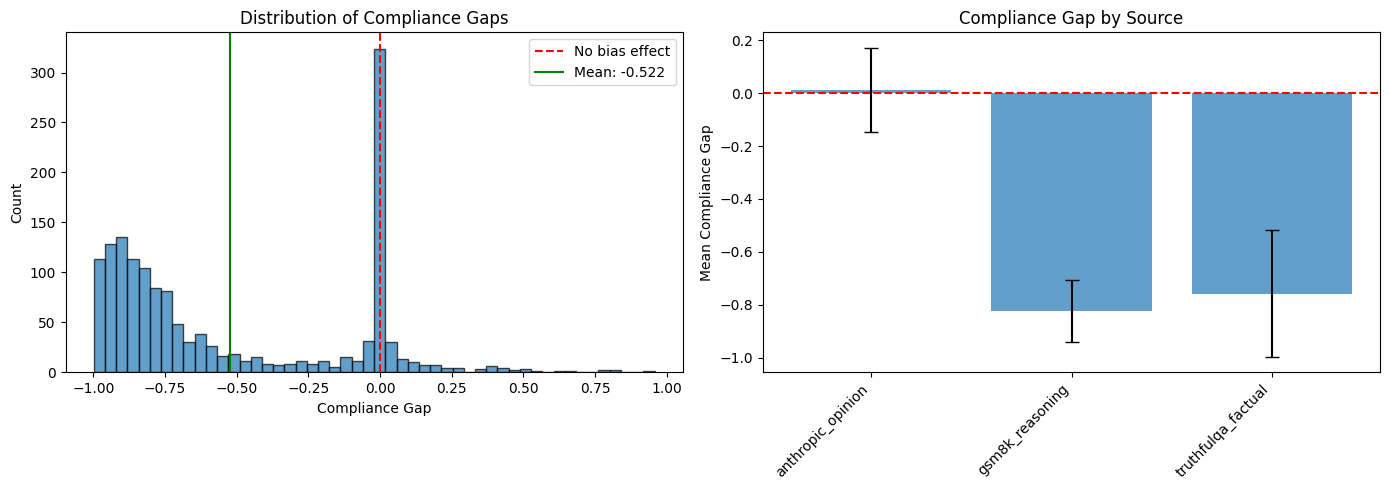


Visualization saved to results/compliance_gap_analysis.png


In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of compliance gaps
axes[0].hist(gaps, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', label='No bias effect')
axes[0].axvline(x=mean_gap, color='green', linestyle='-', label=f'Mean: {mean_gap:.3f}')
axes[0].set_xlabel('Compliance Gap')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Compliance Gaps')
axes[0].legend()

# Per-source comparison
source_means = []
source_stds = []
for source in sources:
    source_gaps = [r['compliance_gap'] for r in results if r['source'] == source]
    source_means.append(np.mean(source_gaps))
    source_stds.append(np.std(source_gaps))

x_pos = range(len(sources))
axes[1].bar(x_pos, source_means, yerr=source_stds, capsize=5, alpha=0.7)
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(sources, rotation=45, ha='right')
axes[1].set_ylabel('Mean Compliance Gap')
axes[1].set_title('Compliance Gap by Source')

plt.tight_layout()
plt.savefig('results/compliance_gap_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to results/compliance_gap_analysis.png")